In [25]:
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    import numpy as np
    import pandas as pd
    from collections import OrderedDict
    import re
    import statsmodels
    from statsmodels.nonparametric.smoothers_lowess import lowess
    import statsmodels.api as sm
    import sklearn
    import os
    import datetime as dt
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    mpl.rcParams['figure.figsize'] = [10,7]
    import seaborn as sb
    from tqdm import tqdm
    import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/CZ4041 Machine Learning Project/Colab

/content/drive/.shortcut-targets-by-id/1ldppAeVJfaoI4cvwZyTCju9jXbD4LI-H/CZ4041 Machine Learning Project/Colab


In [10]:
def expand_df(df):
    data = df.copy()
    data['day'] = data.index.day
    data['month'] = data.index.month
    data['year'] = data.index.year
    data['dayofweek'] = data.index.dayofweek
    data['dayofyear']=data.index.dayofyear
    data['weekofyear']=data.index.weekofyear
    return data

In [8]:
data=pd.read_csv('data/train.csv',parse_dates=['date'],index_col=['date'])

In [ ]:
df=expand_df(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


Int64Index([2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013, 2013,
            ...
            2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017],
           dtype='int64', name='date', length=913000)

#Analysing Yearly Trend

In [ ]:
df1=df[df['year'] > 2014]

1.0634076993666541

In [ ]:
(1+df.groupby('year')[['sales']].mean().pct_change()).mean()

sales    1.061469
dtype: float64

In [ ]:
df[df['year']==2017][['sales']].mean()/df[df['year']==2013][['sales']].mean()

sales    1.353747
dtype: float64

In [ ]:
pd.pivot_table(self.data, index=['store','item','month'],
                                                   columns='dayofweek',
                                                   values='sales', aggfunc=np.mean)

In [ ]:
df_train_norm = data.copy()

"""
The transform function creates the dataframe of the same shape as the original data with the aggrgation method applied to each record. For example
all items 1 sales of store 1 will be divided by a particular number and so on
"""

df_train_norm['sales'] /= data.groupby(['item', 'store'])['sales'].transform('mean')

In [ ]:
data.groupby(['item', 'store'])['sales'].transform('mean')

date
2013-01-01    19.971522
2013-01-02    19.971522
2013-01-03    19.971522
2013-01-04    19.971522
2013-01-05    19.971522
                ...    
2017-12-27    74.037240
2017-12-28    74.037240
2017-12-29    74.037240
2017-12-30    74.037240
2017-12-31    74.037240
Name: sales, Length: 913000, dtype: float64

## Analysing Yearly Trend

## Extrapolating trend

Function extrapolation is never an easy task as even functions that have a similar fit on internal data points can have a very different behaviour outside of them. Check some examples below.

We could try using cross-validation to find the best extrapolation method. The problem is we only have 5 year to do so it is unlikely to be very efficient. When little data available stable methods usually perform the best: they have low variance and there is not much hope of having low bias anyway. So the best solution seems to be picking linear extrapolation or local linear extrapolation with high regularization. The solution with linear trend give us a public score of 13.875. Pretty good for such a "dumb" algorithm! This is also one of the earlier solutions described in XYZT's kernel.

It's unfortunate that we don't have more data to tune the trend. I guess we should stop here. Unless we use one ancient dark and forbidden technique... We can tune the trend using the public score! Yes, it is typically better only to use it during final model validation rather than model parameter tuning - otherwise it's very easy overfit the model. However, in this case we should be fine: we are only tuning one parameter of a pretty stable model. This method gives us expected value of sales in 2018 approximately equal to 60.5, or $trend(2018) \approx 1.158$. Let's just hardcode this value.

The solution with a hardcoded trend give us a public score of 13.852 (and a private score of 12.587), which is pretty damn good!

Just to be on the safe side, I cross-validated "dumb" models with linear, qudratic and hardcoded trend extrapolation, from 2016 Q1 to 2017 Q4 using the same methodology as before. The hardcoded version (HC) generally shows a lower error which is a pretty good sign.

In [72]:
def logSales(sales,invert):
  
  if (invert):
    return sales.apply(math.exp) - 1

  else:
    return (sales + 1).apply(math.log)



In [57]:
df['sales']

date
2013-01-01    13
2013-01-02    11
2013-01-03    14
2013-01-04    13
2013-01-05    10
              ..
2017-12-27    63
2017-12-28    59
2017-12-29    74
2017-12-30    62
2017-12-31    82
Name: sales, Length: 913000, dtype: int64

In [71]:
logSales(df['sales'],False)

date
2013-01-01    2.639057
2013-01-02    2.484907
2013-01-03    2.708050
2013-01-04    2.639057
2013-01-05    2.397895
                ...   
2017-12-27    4.158883
2017-12-28    4.094345
2017-12-29    4.317488
2017-12-30    4.143135
2017-12-31    4.418841
Name: sales, Length: 913000, dtype: float64

In [73]:
log_sales=pd.DataFrame(logSales(df['sales'],False))

logSales(log_sales['sales'],True)

date
2013-01-01    13.0
2013-01-02    11.0
2013-01-03    14.0
2013-01-04    13.0
2013-01-05    10.0
              ... 
2017-12-27    63.0
2017-12-28    59.0
2017-12-29    74.0
2017-12-30    62.0
2017-12-31    82.0
Name: sales, Length: 913000, dtype: float64

N_sales = log(sales+1)

# Analysing Data 

In [11]:
df=expand_df(data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


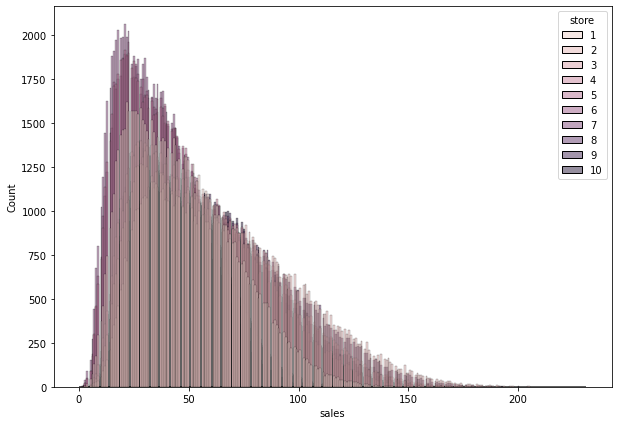

In [22]:
sb.histplot(x='sales',data=df,hue='store')

In [74]:
log_sales=pd.DataFrame((df['sales']+1).apply(math.log))

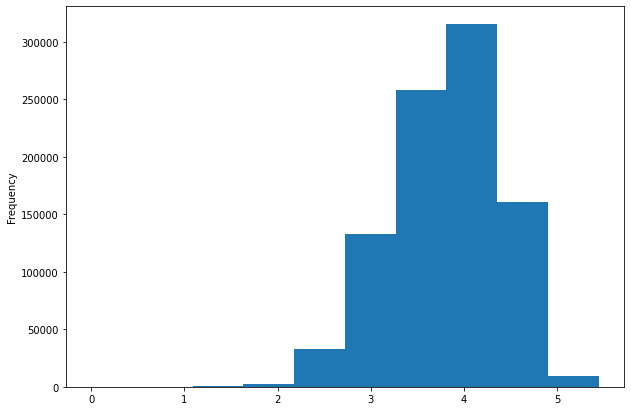

In [79]:
log_sales['sales'].plot(kind='hist')

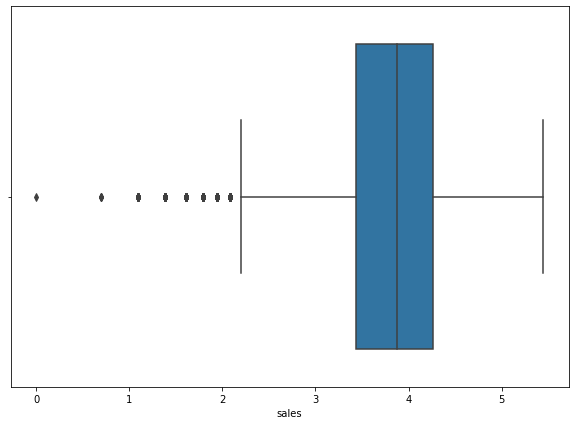

In [52]:
sb.boxplot(x=log_sales.loc[filter]['sales'])

,sales
date,
2013-01-01,2.639057
2013-01-02,2.484907
2013-01-03,2.708050
2013-01-04,2.639057
2013-01-05,2.397895
...,...
2017-12-27,4.158883
2017-12-28,4.094345
2017-12-29,4.317488


In [49]:
log_sales['sales']

date
2013-01-01    2.639057
2013-01-02    2.484907
2013-01-03    2.708050
2013-01-04    2.639057
2013-01-05    2.397895
                ...   
2017-12-27    4.158883
2017-12-28    4.094345
2017-12-29    4.317488
2017-12-30    4.143135
2017-12-31    4.418841
Name: sales, Length: 913000, dtype: float64

2871

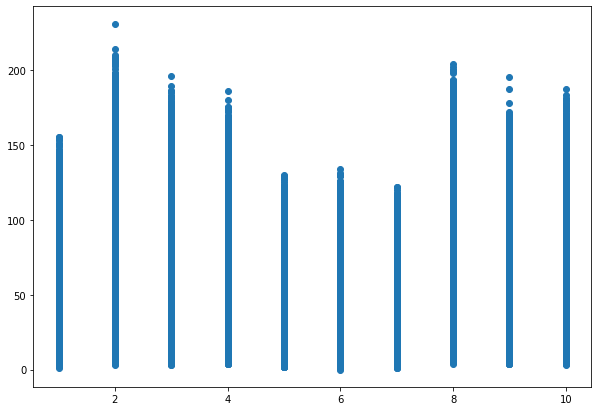

In [38]:
plt.scatter(df['store'],df['sales'])

# MODEL

In [5]:
def getTestData():
  sample_test_data=pd.read_csv('data/test.csv',parse_dates=['date'],index_col=['date'])
  sample_test_data=expand_df(sample_test_data)
  sample_test_data.drop('id',axis=1,inplace=True)
  return sample_test_data

In [129]:
# Just for the reference, here is the code of the "dumb" model
from abc import abstractmethod, ABC

class DumbBase(ABC):

    def __init__(self, growth='quadratic', window_years=None,verbose=False):
        self.growth = growth
        self.window_years = window_years
        self.verbose = verbose
    
    @staticmethod
    def expand_data(df):
        data = df.copy()
        data['day'] = data.index.day
        data['month'] = data.index.month
        data['year'] = data.index.year
        data['dayofweek'] = data.index.dayofweek
        data['dayofyear']=data.index.dayofyear
        data['weekofyear']=data.index.weekofyear
        return data
    
    def _fit_annual_sales(self):
      pass
      #self._annual_sales = (1+pd.pivot_table(self.data,index='store',columns='year',values='sales',aggfunc=np.mean).pct_change(axis=1)).mean(axis=1) Y4


    def _predict_annual_sales(self,store,item):
      return self._annual_sales.at[(store,item)]
    
    @abstractmethod
    def _fit_base_seasonality(self):
        pass
    
    def fit(self, data):
        self.data = self.expand_data(data)
        
        if self.window_years is not None:
          self.data = self.data[self.data['year'] > self.window_years]

            
        self.base_sales = self.data['sales'].mean()
        self.data['sales'] /= self.base_sales
        self._fit_base_seasonality()
        self._fit_annual_sales()        
        
    @abstractmethod
    def _predict_base_seasonality(self, item, store, date):
        pass
  
    def predict(self, data):
        self.predictions=[]
        for i, row in data.iterrows():
          date, item, store = row[['dayofweek','month','year']], row['item'], row['store']
          
          if(self.verbose):
            print("base {} || annual {} ".format(self._predict_base_seasonality(item, store, date),self._predict_annual_sales(store,item)))
            print('_______________________________________')

          pred_sales = self.base_sales * self._predict_base_seasonality(item, store, date) * 1.079843186922517 # self._predict_annual_sales(store,item) 
          self.predictions.append(pred_sales)

In [130]:
class MODEL1(DumbBase):

  def _fit_base_seasonality(self):

    self.store_item_table = pd.pivot_table(self.data, index='store', columns='item',
                                            values='sales', aggfunc=np.mean)
    self.month_table = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)
    self.dow_table = pd.pivot_table(self.data, index='dayofweek', values='sales', aggfunc=np.mean)

  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    base_sales = self.store_item_table.at[store, item]
    seasonal_sales = self.month_table.at[month, 'sales'] * self.dow_table.at[dow, 'sales']
    return base_sales * seasonal_sales  



class MODEL2(DumbBase):

  def _fit_base_seasonality(self):

    """
    sales = base(store) * s(dayofweek, item) * s(month) * trend(year)
    """

    #Day pattern
    self.agg_dayItemTable = pd.pivot_table(self.data, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)

    # Month pattern
    self.agg_monthTable = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)

    # Store pattern
    self.agg_storeTable = pd.pivot_table(self.data, index='store', values='sales', aggfunc=np.mean)


  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    dayFactor = self.agg_dayItemTable.at[dow,item]
    
    monthFactor = self.agg_monthTable.at[month, 'sales']

    storeFactor = self.agg_storeTable.at[store, 'sales']

    return dayFactor * monthFactor * storeFactor




class MODEL3(DumbBase):

  def _fit_base_seasonality(self):
    self.agg_store_table = pd.pivot_table(self.data, index=['store','item','month'],
                                                   columns='dayofweek',
                                                   values='sales', aggfunc=np.mean)
    
  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year
    return self.agg_store_table.at[(store,item,month),dow]


class MODEL4(DumbBase):
    """
    sales = s(dayofweek, item, store) * s(month) * trend(year)
    """
    
    def _fit_base_seasonality(self):
  
        self.month_table = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)

        self.dow_item_store_table = pd.pivot_table(self.data, index=['item', 'store'],
                                                   columns='dayofweek',
                                                   values='sales', aggfunc=np.mean)
        
    def _predict_base_seasonality(self, item, store, date):
        dow, month, year = date.dayofweek, date.month, date.year
        return self.month_table.at[month, 'sales'] * self.dow_item_store_table.at[(item, store), dow]

class MODEL5(DumbBase):
    """
    sales = base(item) * s(dayofweek, store) * s(month) * trend(year)
    """
    
    def _fit_base_seasonality(self):
        self.item_table = pd.pivot_table(self.data, index='item', values='sales', aggfunc=np.mean)

        self.month_table = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)

        self.dow_store_table = pd.pivot_table(self.data, index='dayofweek', columns='store',
                                             values='sales', aggfunc=np.mean)
        
    def _predict_base_seasonality(self, item, store, date):
        dow, month, year = date.dayofweek, date.month, date.year
        base_sales = self.item_table.at[item, 'sales']
        seasonal_sales = self.month_table.at[month, 'sales'] * self.dow_store_table.at[dow, store]
        return base_sales * seasonal_sales

  
class MODEL6(DumbBase):

  def _fit_base_seasonality(self):

    """
    sales = s(dayofweek, item) * s(month,item) * s(store,item) * trend(year)
    """

    self.data['sales'] *= self.base_sales

    #Day pattern
    self.agg_dayTable = pd.pivot_table(self.data, index='dayofweek', values='sales', aggfunc=np.mean)

    # Month pattern
    self.agg_monthTable = pd.pivot_table(self.data, index='month' , values='sales', aggfunc=np.mean)
    self.agg_monthTable/=self.base_sales
    # Store pattern
    self.agg_storeTable = pd.pivot_table(self.data, index='store', columns='item' , values='sales', aggfunc=np.mean)
    self.agg_storeTable/=self.base_sales

  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    dayFactor = self.agg_dayTable.at[dow,'sales']
    
    monthFactor = self.agg_monthTable.at[month,'sales']

    storeFactor = self.agg_storeTable.at[store,item]

    return (dayFactor * monthFactor * storeFactor)/self.base_sales


class MODEL8(DumbBase):

  def _fit_base_seasonality(self):

    """
    sales = base(store) * s(dayofweek, item) * s(month) * trend(year)
    """

    #Day pattern
    self.agg_dayItemTable = pd.pivot_table(self.data, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)
    
    self.agg_dayItemTable*=self.base_sales
    # Month pattern
    self.agg_monthTable = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)

    # Store pattern
    self.agg_storeTable = pd.pivot_table(self.data, index='store', values='sales', aggfunc=np.mean)


  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    dayFactor = self.agg_dayItemTable.at[dow,item]
    
    monthFactor = self.agg_monthTable.at[month, 'sales']

    storeFactor = self.agg_storeTable.at[store, 'sales']

    return (dayFactor * monthFactor * storeFactor) / self.base_sales

# Log Model

In [121]:
class LogBase(ABC):

    def __init__(self, growth='quadratic',remove_out = False,window_years=None,verbose=False):
        self.growth = growth
        self.window_years = window_years
        self.verbose = verbose
        self.remove_out = remove_out
    
    @staticmethod
    def expand_data(df):
        data = df.copy()
        data['day'] = data.index.day
        data['month'] = data.index.month
        data['year'] = data.index.year
        data['dayofweek'] = data.index.dayofweek
        data['dayofyear']=data.index.dayofyear
        data['weekofyear']=data.index.weekofyear
        return data
    
    def _fit_annual_sales(self):
      return 1
      #self._annual_sales = (1+pd.pivot_table(self.data,index='store',columns='year',values='sales',aggfunc=np.mean).pct_change(axis=1)).mean(axis=1) Y4
     # self._annual_sales = (1+pd.pivot_table(df1,index=['store','item'],columns='year',values='sales',aggfunc=np.mean).pct_change(axis=1)).mean(axis=1) #Y5

    def _predict_annual_sales(self,store,item):
      return self._annual_sales.at[(store,item)]
    
    @abstractmethod
    def _fit_base_seasonality(self):
        pass
    
    def fit(self, data):
        self.data = self.expand_data(data)
        
        if self.window_years is not None:
          self.data = self.data[self.data['year'] > self.window_years]


        self.data['sales'] = self.convert_log_Sales(self.data['sales'],False)

        if (self.remove_out):
          self.remove_outliers()

        self.base_sales = self.data['sales'].mean()
        self.data['sales'] /= self.base_sales
        self._fit_base_seasonality()
        self._fit_annual_sales()        

    def convert_log_Sales(self,sales,invert):


      if (invert):
        return sales.apply(math.exp) - 1

      else:
        return (sales + 1).apply(math.log)  

    
    def remove_outliers(self):
      Q1 = self.data['sales'].quantile(0.25)
      Q3 = self.data['sales'].quantile(0.75)
      IQR = Q3 - Q1    #IQR is interquartile range. 

      filter = (self.data['sales'] >= Q1 - 1.5 * IQR) & (self.data['sales'] <= Q3 + 1.5 *IQR)
      self.data = self.data.loc[filter]  


    @abstractmethod
    def _predict_base_seasonality(self, item, store, date):
        pass
  
    def predict(self, data):
        self.predictions=[]
        for i, row in data.iterrows():
          date, item, store = row[['dayofweek','month','year']], row['item'], row['store']
          
          if(self.verbose):
            print("base {} || annual {} ".format(self._predict_base_seasonality(item, store, date),self._predict_annual_sales(store,item)))
            print('_______________________________________')

          pred_sales = (math.exp(self.base_sales * self._predict_base_seasonality(item, store, date))-1)* 1.079843186922517 # self._predict_annual_sales(store,item) 
          self.predictions.append(pred_sales)

In [122]:
class MODEL7(LogBase):

  def _fit_base_seasonality(self):

    """
    sales = base(store) * s(dayofweek, item) * s(month) * trend(year)
    """

    #Day pattern
    self.agg_dayItemTable = pd.pivot_table(self.data, index='dayofweek', columns='item', values='sales', aggfunc=np.mean)

    # Month pattern
    self.agg_monthTable = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean)

    # Store pattern
    self.agg_storeTable = pd.pivot_table(self.data, index='store', values='sales', aggfunc=np.mean)


  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    dayFactor = self.agg_dayItemTable.at[dow,item]
    
    monthFactor = self.agg_monthTable.at[month, 'sales']

    storeFactor = self.agg_storeTable.at[store, 'sales']

    return dayFactor * monthFactor * storeFactor

# Reference Model

In [152]:
from abc import abstractmethod, ABC

class DumbBase(ABC):

    def __init__(self, growth='quadratic', window_years=None,verbose=False):
        self.growth = growth
        self.window_years = window_years
        self.verbose = verbose
    
    @staticmethod
    def expand_data(df):
        data = df.copy()
        data['day'] = data.index.day
        data['month'] = data.index.month
        data['year'] = data.index.year
        data['dayofweek'] = data.index.dayofweek
        data['dayofyear']=data.index.dayofyear
        data['weekofyear']=data.index.weekofyear
        return data

    def _fit_annual_sales(self):
      pass
      #self._annual_sales = (1+pd.pivot_table(self.data,index='store',columns='year',values='sales',aggfunc=np.mean).pct_change(axis=1)).mean(axis=1) Y4


    def _predict_annual_sales(self,store,item):
      return self._annual_sales.at[(store,item)]
    
    @abstractmethod
    def _fit_base_seasonality(self):
        pass
    
    def fit(self, data):
        self.data = self.expand_data(data)
        
        if self.window_years is not None:
          self.data = self.data[self.data['year'] > self.window_years]

            
        self.base_sales = self.data['sales'].mean()

        self._fit_base_seasonality()
        self._fit_annual_sales()        
        
    @abstractmethod
    def _predict_base_seasonality(self, item, store, date):
        pass
  
    def predict(self, data):
        self.predictions=[]
        for i, row in data.iterrows():
          date, item, store = row[['dayofweek','month','year']], row['item'], row['store']
          
          if(self.verbose):
            print("base {} || annual {} ".format(self._predict_base_seasonality(item, store, date),self._predict_annual_sales(store,item)))
            print('_______________________________________')

          pred_sales = self._predict_base_seasonality(item, store, date) * 1.1569026456054416 #1.1569026455945277 # self._predict_annual_sales(store,item) 
          self.predictions.append(pred_sales)

In [153]:
class MODEL9(DumbBase):

  def _fit_base_seasonality(self):

    """
    sales = base(store) * s(dayofweek, item) * s(month) * trend(year)
    """

    #Day pattern
    self.agg_storeItemTable = pd.pivot_table(self.data, index='store', columns='item', values='sales', aggfunc=np.mean)
    
    # Month pattern
    self.agg_monthTable = pd.pivot_table(self.data, index='month', values='sales', aggfunc=np.mean) / self.base_sales

    # Store pattern
    self.agg_dayTable = pd.pivot_table(self.data, index='dayofweek', values='sales', aggfunc=np.mean) / self.base_sales


  def _predict_base_seasonality(self, item, store, date):
    dow, month, year = date.dayofweek, date.month, date.year

    storeFactor = self.agg_storeItemTable.at[store,item]
    dayFactor = self.agg_dayTable.at[dow, 'sales']
    monthFactor = self.agg_monthTable.at[month, 'sales']

    

    return dayFactor * monthFactor * storeFactor

In [ ]:
MODELS = [MODEL1(window_years=2014, verbose=False),MODEL2(window_years=2014, verbose=False),MODEL3(window_years=2014, verbose=False),
          MODEL4(window_years=2014, verbose=False),MODEL5(window_years=2014, verbose=False)]

In [ ]:
for model in tqdm(MODELS):
  model.fit(data)

 20%|██        | 1/5 [00:00<00:03,  1.32it/s]

Dumb fit: functional annual growth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
 40%|████      | 2/5 [00:01<00:02,  1.32it/s]

Dumb fit: functional annual growth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
 60%|██████    | 3/5 [00:02<00:01,  1.31it/s]

Dumb fit: functional annual growth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
 80%|████████  | 4/5 [00:03<00:00,  1.32it/s]

Dumb fit: functional annual growth


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
100%|██████████| 5/5 [00:03<00:00,  1.32it/s]

Dumb fit: functional annual growth


In [ ]:
for model in tqdm(MODELS):
  model.predict(getTestData())

  0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  
100%|██████████| 5/5 [02:54<00:00, 34.84s/it]


In [125]:
predictions = (np.round(model.predictions))
predictions = list(map(int, predictions))

In [157]:
model = MODEL9(window_years=None, verbose=False)
model.fit(data[data['sales'] < 200])
model.predict(getTestData())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series.  To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  


In [158]:
model.predictions[:10]

[12.457197739365832,
 14.500722067534559,
 14.543598805695005,
 15.552304657662456,
 16.584860104809593,
 17.637880394023302,
 18.680453828513436,
 12.457197739365832,
 14.500722067534559,
 14.543598805695005]

In [159]:
createSubmission(model.predictions,fileName="data/M9_Y12.csv")

# Helpers

In [101]:
leaderboardData = pd.read_csv("data/test_prediction_answer.csv")

In [126]:
Comparision=leaderboardData[['sales']].copy()
Comparision['predictions'] = predictions

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


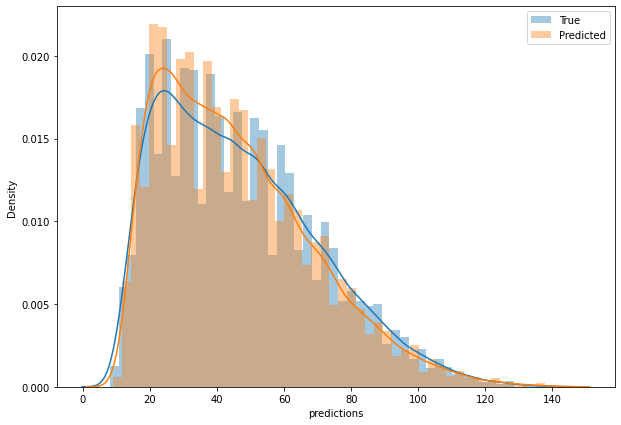

In [127]:
sb.distplot(Comparision.sales,label='True')
sb.distplot(Comparision.predictions,label='Predicted')
plt.legend()

In [ ]:
(abs(Comparision.sales - np.round(Comparision.predictions))).mean()

1.5125777777777778

Mi_Y1 = yearly growth @ 1.079843186922517 

Mi_Y2 = yearly growth @ 1.158 (worse performance)

Mi_Y3 = yearly growth @ quadratic

M2_Y4 = individual yearly growth pattern on index = store , columns = year

M2_Y5 = individual yearly growth pattern on index = [store,item] , columns = year

M6_Y6 = yearly growth @ 1.1569026455945277 

M7_Y7 = yearly growth @ 1.1569026455945277 && Log Sales 

M7_Y8 = yearly growth @ 1.1569026455945277  && Log Sales + removed outliers 

M7_Y9 = yearly growth @ 1.079843186922517 && Log Sales + removed outliers

M8_Y1 = reference mode + yearly growth @ 1.079843186922517 

M9_Y10 = 1.156902645594527

M9_Y11 = 1.1569026456054416

In [108]:
def createSubmission(predictions,fileName="data/submission.csv"):
  df=pd.DataFrame(predictions)
  df=df.reset_index()
  df.columns=['id','sales']
  df.to_csv(fileName,index=False)

In [ ]:
for index,model in enumerate(MODELS):
  createSubmission(model.predictions,fileName="data/M{}_Y3.csv".format(index+1))

<a id="SectionOutro"></a>
# Outro

For our final submission, we selected the original "dumb" model (with a hardcoded trend) and the "dumb" model with weekly seasonalities fit for every item separately. The latter had a low and stable cross-validated error and a pretty good public score of 13.845. This choice has payed off: the model got a private score of 12.580 and brought our team to Top 1! Yay! It was quite close to the second best private score of 12.584 by jnng. 

Going through this kernel again, I think the key points contribusing to *Fantastic 2*'s victory in this competions were:
- Realization that the data is synthetic;
- Ideas inspired by other public kernels;
- Careful use of a public score to tune the trend;
- Cross-validation to select the best model;
- Luck =)

On ideas from public kernels: [XYZT's kernel](https://www.kaggle.com/thexyzt/keeping-it-simple-by-xyzt) made a big difference. To be honest, in this era of Gradient Boosting and DNN, I'm not sure we would have thought of such a simple approach to model sales volumes. Simple yet very effective! The leaderboard changed drastically after XYZT shared it - it was very funny to see how at least a dozen top submissions appreared by simply forking his script ^^

And... that's it folks! Thanks for reading. Please share your thoughts in the comment section. And cross-validate responsibly.

> \---------------------------
>
> Stay awesome Kaggle,
>
> Mysterious Ben
>
> \---------------------------